# <center> **Лекция 4:** Компьютерное зрение. Задача Object Detection. Методы глубокого обучения. Часть 1. </center>
# <center>Компьютерное зрение. Подготовка изображений для модели. Аугментация данных. Внимание в сверточных сетях. Аннотации. </center>

----

<br>
</br>

<center> <img src=./../src/imgs/augmentations.png> </center>

<br>
</br>
----
<br>
</br>

<center> <img src=./../src/imgs/ObjD.png> </center>

<br>
</br>


----
### _Аугментация изображений_
----


* Аугментация (Augmentation) изображений - это техника увеличения объема обучающей выборки путем различных искажений исходных данных, также отдельный вид регуляризации в компьютерном зрении.
* Аугментация __увеличивает обобщающую способность__ модели.
* Именно данная техника дала существенный прирост качества на ImageNet в таких архитектурах как AlexNet(2012), GoogleNet(2014), VGG(2015), ResNet(2016).
* Аугментацию можно делать как на стадии обучения, __так и на стадии тестирования__ модели.
* Удобно реализовывать аугментацию во время обучения модели.



#### Типичный пайплайн тренировки с аугментацией изображений:

<br>
</br>

<center> <img src=./../src/imgs/aug_pipeline.png> </center>

<br>
</br>


#### Что используют чаще всего на практике помимо стандартного функционала фреймворков PyTorch/TensorFlow:

* [Библиотека Albumentations - GitHub](https://github.com/albumentations-team/albumentations)
* [Benchmark](https://github.com/albumentations-team/albumentations#benchmarking-results)
* [Documentation](https://albumentations.ai/docs/)
* [Demo](https://demo.albumentations.ai/)


### Техники аугментации изображений - __MixUp__, __CutOut__, __CutMix__:


<br>
</br>

<center> <img src=./../src/imgs/cutmix.png> </center>

<br>
</br>

[CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)


Интересные проекты для автоматизации процесса аугментации с различными техниками:
1. [Fast AutoAugment by Kakao Brain](https://github.com/kakaobrain/fast-autoaugment)
2. [DADA: Differentiable Automatic Data Augmentation using rendering](https://github.com/VDIGPKU/DADA)
3. [Differentiable Render using GPU for optimised augmentations by KORNIA](https://kornia.readthedocs.io/en/latest/augmentation.html)
4. [PyTorch Lighting + kornia: practical example](https://github.com/kornia/kornia-examples/blob/master/kornia_lightning_mnist_gpu.ipynb)




## __План на сегодня:__

----
### 1. _Классические методы и подходы к решению задачи Object Detection._
### 2. _Подходы глубокого обучения к решению задачи Object Detection._
### 3. _Use Case_

# Часть 1: Классические методы и подходы к решению задачи Object Detection.


____

__Базовые концепции задачи Object Detection. Метрики оценки качества работы моделей Object Detection.__

----

_Object Detection_ vs _Object Recognition_:

- Object Recognition - определяет присутствие определенного объекта в кадре видеопотока/изображения и на выходе выдает метку и вероятность
- Ojbect Detection - выдает то же что и Object Recognition плюс bounding box с координатами (x,y, w,h), указывающий положение объекта в кадре видеопотка/изображения


В основе любого решения Object Detection алгоритма стоит Object Recognition алгоритм. Чтобы локализовать объект, мы в первую очередь должны выбрать сабрегионы изображения, которые называются патчами (__patches__) и отдать их в качестве входа в алгоритм Object Recognition. Координаты объекта определяются по координатам патча, где алгоритм Object Recognition выдал наибольшую вероятность данного объекта (точность что это именно тот объект).

<br>
</br>

<center> <img src=./../src/imgs/odor.png> </center>

<br>
</br>

Простыми словами, суть работы алгоритма Object Detection по набору N-го количества патчей, понять находится ли объект в данном признаковом пространстве или нет. И по M наборам патчей - локализовать искомый объект и выдать на выходе bounding box'ы с координатами искомого объекта и метрикой качества.

<br>
</br>

----
_Самый простой и глупый алгоритм решения задачи OD - __Метод Скользящего Окна__ (Sliding Window)_:

----

Идея метода скользящего окна, заключается в том, что самый очевидный способ выбирать патчи - это использовать некое скользящее окно (sliding window), которое проходит по изображению, та область которая изображения, которая в данный момент покрыта окном - считается патчем и подается на вход Object Recognition алгоритму. Также мы должны пройтись окном не только по всему изображению, а также по его разным масштабам и отношением сторон (то есть моделируем еще и изменение размера и пропорций окна, являющиеся гиперпараметрами). В данном подходе существенный __недостаток__ - это то, что в итоге мы классифицируем десятки патчей, что является вычислительно трудоемким и долгим процессом.

<br>
</br>

<center> <img src=./../src/imgs/slidingwindow.png> </center>

<br>
</br>


----
Преодолеть вышеуказанные проблемы помогает подход получивший название __Region Proposals__ (Регионы предположений):

----


<br>
</br>

<center> <img src=./../src/imgs/regionproposals.png> </center>

<br>
</br>


В подходе Region Proposals на __вход__ алгоритма подается изображение, а на выходе мы получаем патчи, которые с наибольшей вероятностью содержат все искомые объекты на изображении (такие найденные патчи называются Region Proposal). Такие __Regional Proposals__ могут быть зашумленными, перекрываться друг с другом, а также вовсе могут не содержать никаких объектов в патче.

Идея заключается в том, что среди таких __Regional Proposals__ будут содержаться правильные регионы, которые содержат объекты, которые далее будут классифицированы при помощи уже __Object Recognition__ алгоритма.

Очень часто, __Regional Proposals__ алгоритмы используют метод работы через сегментацию. Сегментация осуществляется путем группировки смежных регионов на основе метрик сходства по какому-либо параметру - по цвету, текстуре и тд. В отличие от __sliding window__ подхода, где объекты находятся на пиксельном уровне, __Regional Proposals__ алгоритмы группируют пиксели в небольшое количество сегментов и работают уже на уровне таких сегментов, поэтому такие алгоритмы генерируют на порядок меньшее количество патчей, но сохраняют более "информативную" часть изображения, что делает их удобнее для дальнейшего использования в классификации в алгоритмах __Object Recognition__.
Важным свойством Regional Proposal подхода является высокая оценка полноты.

Некоторые из популярных Regional Proposal алгоритмов (классические методы, которые используются до сих пор):
1. [Objectness](https://medium.com/@zhao.nathan/understanding-objectness-in-object-detection-models-5d8c9d032488)
2. [Constrained Parametric Min-Cuts for Automatic Object Segmentation](https://www.cs.utexas.edu/~cv-fall2012/slides/che-chun-expt.pdf)
3. [Category Independent Object Proposals](https://vision.cs.uiuc.edu/proposals/)
4. [Randomized Prim](https://openaccess.thecvf.com/content_iccv_2013/papers/Manen_Prime_Object_Proposals_2013_ICCV_paper.pdf)
5. [Selective Search](https://www.koen.me/research/selectivesearch/)

<br>
</br>

---

__Sliding Window vs Regional Proposals__:

---

Sliding Window:
- Работают на уровне пикселей
- Используют окна разных масштабов и пропорций
- Генерируют десятки тысяч патчей для Object Recognition


Region Proposals:
- Группируют пиксели в сегменты/кластеры и работают уже с ними
- Генерируют на порядок меньше патчей для Object Recognition
- Обладают высокой оценкой полноты Recall

____

__Как оценить и понять что мой алгоритм OD работает качественно и соответственно какие метрики использовать:__

----

Чтобы понять как оценивать работу алгоритмов __OD__ вспомним про такие метрики как _Precision, Recall, F1-Score, ROC-AUC_:


<br>
</br>

<center> <img src=./../src/imgs/metrics_tp_fn_etc.png> </center>

<br>
</br>


__Что такое True Positives (TP), False Positives (FP), True Negatives (TN) и False Negatives (FN)?__

<br>
</br>

## $Precision = \frac {TP} {(TP + FP)} = \frac {TP} {\sum ground truths}$

То есть, простыми словами - как много обнаруженных объектов действительно удалось захватить в данном пространстве объектов (как много обнаруженных объектов действительно являются объектами).

<br>
</br>

## $Recall = \frac {TP} {(TP + FN)} = \frac {TP} {\sum predictions}$

Как много объектов алгоритм вообще смог обнаружить в результате работы.

<br>
</br>

## $F1-Measure = 2 * \frac {(Recall * Precision)} {(Recall + Precision)} = \frac {2TP} {2TP + FP + FN}$

<br>
</br>


__Recall__ важен для Region Proposals алгоритмов, так как __большое количество FP хоть и замедляет скорость работы, но не особо влияет на итоговую точность обнаружения объекта__ (так как FP патчи все равно будут отброшены уже Object Recognition алгоритмом). В то время, как FN на точность влияет очень сильно, так как приводит к пропуску патчей __содержащих__ необходимые нам объекты.

<br>
</br>

__Intersection over Union (IoU)__:
<br>
</br>

<center> <img src=./../src/imgs/iou.png> </center>

<br>
</br>

Метрика которая в комбинации с другими метриками или как составная часть в других метрик используется для оценки качества Object Detection алгоритмов. Используется чтобы определить верен ли предсказанный bounding box. Площадь пересечения предсказанного bounding box'a с ground truth bounding box'ом делится на площать их объединения. Предсказание считается TP если метрика IoO >= заданного порога, иначе предсказание считается FP.

<br>
</br>

__Метрика Average Precision (AP)__:
Для понимания лучше рассмотрим следующий пример, допустим у нас имеется 2 изображения:

<br>
</br>

<center> <img src=./../src/imgs/iou2.png> </center>

<br>
</br>

У нас есть 3 объекта (зеленый bounding box) и 4 предсказания (красный bounding box) с соответствующими метриками точности Object Recognition алгоритма об уверенности что данный объект точно определен. Построим табличку по предсказаниям P1,P2, P3, P4 и упорядочим эти данные по confidence скору по убыванию:

<br>
</br>

<center> <img src=./../src/imgs/AP.png> </center>

<br>
</br>

Теперь считаем метрику __IoU__ для каждого предсказания. И если IoU >= 0.5 мы считаем предсказание TP (в противном случае FP). В случае с P3 и P4 bounding box'ами, __так как "околообъектный" P3 < P4, то P3 будет рассматриваться как FP.__ Теперь нам необходимо посчитать __Precision__ и __Recall__.

Кратко подведем итоги по операциям:
1. Каждая строка описывает предсказанный бокс, строки упорядочены по confidence.
2.  Считаем IoU, и если IoU > 0.5, то бокс TP, иначе FP. Если для одного объекта предсказано несколько боксов, то бокс с бОльшим IoU считается TP, а все остальные FP.
3. Считаем Precision: доля TP от общего числа детекций (на текущей строке и выше).
4. Считаем Recall: доля TP (на текущей строке и выше) от общего числа объектов (всего их 3).

<br>
</br>

Теперь когда у нас есть все метрики, нам необходимо построить Precision-Recall кривую:

<br>
</br>

<center> <img src=./../src/imgs/prrec.png> </center>

<br>
</br>

__Площадь под кривой Precision-Recall называется Average Precision (AP) и вычисляется как__:

<br>
</br>

## $AP = \int_{0}^{1} p(r)dr$

Но так работают крайне редко, и соответственно перед вычислением PR-кривой и вычислением AP метрики, кривую PR очень удобно и полезно сгладить. Для этого на каждом значении Recall мы заменяем значение Precision на максимальное значение правее от него:

<br>
</br>

<center> <img src=./../src/imgs/prrc_smoothed.png> </center>

<br>
</br>

Процесс сглаживание можно описать при помощи следующей операции:

<br>
</br>

## $p_{interp(r)} = \[\max_{\tilde{r} \ : \tilde{r} \geq r}\] p(r)$

Вычисление по такому методу мы избавляемся от лишнего шума и вычисленно AP на такой кривой менее подвержено небольшим колебаниям в ранге бокса (confidence).

<br>
</br>

__Mean Average Precision (mAP)__:

<br>
</br>

__mAP__ - это среднее по AP для всех классов. Чтобы вычислить mAP в первую очередь необходимо вычислить AP для каждого класса объектов:

<br>
</br>

## $AP = \frac {\sum AP |class|} {#classes}$

<br>
</br>

Для разных датасетов mAP вычисляется со своими корректировками:

1. __PASCAL VOC 2010-2012. Area Under Curve (AUC):__

Для VOC AP вычисляется по другому (без аппроксимации). PR-кривая делится на участки в тех точках, где максимальное значение Precision падает. Далее AP считается как сумма площадей прямоугольников:

## $AUC = \sum (r_n_+_1 - r_n) * p_{interp} * (r_n_+_1) $

<br>
</br>

<center> <img src=./../src/imgs/pascalvoc_map.png> </center>

<br>
</br>


2. __MS COCO mAP:__

В VOC детекция считалась TP только для одного значения __IoU>0.5.__ Таким образом боксы с разным IoU (например, 0.6 и 0.9) имеют одинаковый вес при подсчете mAP, что вносит некоторый bias в эту метрику.

Чтобы избежать этого, в COCO mAP считается для нескольких порогов IoU (AP@[.5:.05:.95]), после чего берется их среднее (т.е. mAP это среднее от среднего и от среднего). Кроме того, используется аппроксимированное AP с 101 точкой (диапазон [0:.01:1]).

<br>
</br>

## $mAP_{COCO} = \frac {mAP_0.5 + mAP_0.55 + ... + mAP_0.95} {10}$


____

__Датасеты для тренировки моделей Object Detection.__

----

<br>
</br>

1. [MS COCO](https://cocodataset.org/#home)
* 330K изображений
* 80 классов объектов
* 1.5М объектов размечено боксами (~200K изображений)
* Содержит instance segmentation, keypoints для 250К человек и описание контекста сцены
* Размер ~25ГБ


2. [Open Images Dataset](https://storage.googleapis.com/openimages/web/factsfigures.html)
* 9M изображений
* 600 классов объектов
* 16M объектов размечено боксами (1.7М изображений)
* Сожержит instance segmentation, свойства объектов, взаимодействия между объектами и парами объектов и описание действий человека в сцене
* Размер ~500ГБ

3. [ImageNet](www.image-net.org)
* 14M изображений
* 20K классов объектов (в том числе 120 пород собак)
* На 1.5М изображений есть разметка боксами
* В основном используется для предобучения моделей
* Размер ~150ГБ

____

__[Алгоритм Selective Search (2012) для задачи Object Detection](https://learnopencv.com/selective-search-for-object-detection-cpp-python/).__

----

<br>
</br>


Selective Search (SS) это алгоритм семейства region proposal (RP).

<br>
</br>

<center> <img src=./../src/imgs/selective_Search.png> </center>

<br>
</br>

Достоинства:
1. инвариантен к размерам объектов;
2. относительно высокая скорость работы;
3. высокая оценка полноты (recall).

Алгоритм иерархически итеративно группирует схожие регионы основываясь на метриках сходства по цвету, текстуре,размеру и соответствию форм. На вход алгоритма поступает изображение, которое предварительно сегментировано на основе интенсивности пикселей

Можем ли мы использовать эту сегментацию как RPs?

Ответ - нет, по причинам:
1. большинство объектов имеют два и более сегментов;
2. для окклюдированных объектов (например, чашка с налитым кофе, или чашка на блюдце) не могут быть сгенерированы RPs. Если попытаемся
исправить первую проблему при помощи объединения смежных сегментов, то в конечном итоге можем получить, что один сегмент будет покрывать два объекта. Но наша основная задача - найти как можно больше RPs, которые имеют высокое перекрытие с объектами.

____

__[Алгоритм Viola-Jones задачи Object Detection](https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html).__

----


__Метод Виолы-Джонса для детекции объектов (VJ)__ был предложен Полом Виолой и Майклом Джонсоном в статье “Rapid Object Detection using a Boosted Cascade of Simple Features” в 2001. Основан на каскаде классификаторов с использованием (в оригинале) признаков Хаара (Haar features). Это классический ML-подход где т.н. каскадная функция обучается на датасете из позитивных (содержащих объект) и негативных (без объекта) изображений.




__Признаки Хаара (Haar-like features).__


Чтобы обучить классификатор необходимы признаки. Для этого используются HFs. HFs основаны на вейвлетах Хаара (wavelet - функция позволяющая анализировать различные частотные компоненты данных). Каждый HF состоит из смежных прямоугольных областей, а его значение вычисляется как вычитание суммы интенсивности пикселей под белой прямоугольной областью из суммы под черной областью. По сути каждый HF это ядро(kernel) свертки. Бывают 2/3/4-прямоугольными.

<br>
</br>

<center> <img src=./../src/imgs/haarfeat.png> </center>

<br>
</br>

VJ использует sliding window (SW) подход для поиска объектов на изображении. Поэтому вычислять HFs (если их сотни или тысячи) для каждой позиции SW и для каждого масштаба очень затратно. Поэтому для быстрого вычисления HFs был использован метод integral image.



__Интегральное изображение (integral image).__


Интегральное изображение - это алгоритм для быстрого вычисления HFs, что позволяет VJ работать в real-time даже на CPU. В основе алгоритма лежит матрица интегрального представления, в которой каждый элемент вычисляется как сумма элементов выше и левее данного элемента плюс сам элемент:

## $I(x, y) = \sum_{i=j=1}^{i \leq W , j \leq H} J(i, j)$


Для более эффективного расчета используется рекуррентная формула:

## $I(x, y) = i(x,y) + I(x,y - 1) + I(x-1, y) - I(x-1, y-1)$

<br>
</br>

<center> <img src=./../src/imgs/integralimg.png> </center>

<br>
</br>

Метод реализован в OpenCV как cv2.integral().


____

__Окей достали огромное количество признаков, как их быстро где-то использовать - Алгоритм AdaBoost:__

----

Под признаком подразумевается определенный HF примененной к определенной области окна. Рассмотрим визуальный пример:

<br>
</br>

<center> <img src=./../src/imgs/haarfaces.png> </center>

<br>
</br>

У нас есть два HFs, которые образуют хорошие признаки (в рамках face detection):

1. регион глаз обычно темнее региона щек и носа
2. глаза темнее чем переносица

Но если применить эти же HFs в другие области окна (например, на уровне щек), то они дадут уже не такие хорошие признаки. И в результате, даже если использовать окно размером 24x24, то применяя HFs во все возможные позиции окна, мы получим более сотни тысяч признаков...

Как же выбрать нужные из них? Это достигается при помощи Adaboost:

1. Присвоить одинаковый вес каждому изображению из датасета
2. Вычислить признаки для каждого изображения из датасета
3. Для каждой полученного признака найти порог (train), который лучше всего классифицирует изображения на позитивные (есть объект) и негативные (объекта нет)
4. Рассчитать ошибку классификации для каждого признака (на всех изображениях)
5. Выбрать те признаки, которые дают наименьшую ошибку классификации
6. Увеличить вес тех изображений, на которых признаки ошибаются чаще всего
7. Если заданное число признаков найдено, или необходимая точность классификации достигнута, то завершить процесс, иначе перейти к п.2

Каждый отобранный признак образует слабый классификатор (weak classifier). Финальная оценка классификации вычисляется как взвешенная сумма слабых классификаторов.

Авторы VJ использовали в итоге 6000 признаков и скользящее окно (SW) размером 24x24 (т.е. это минимальное разрешение объекта, объекты меньших размеров не могут быть классифицированы). Таким образом, для каждой позиции SW и для каждого масштаба необходимо вычислять 6000 признаков, что все еще достаточно вычислительно затратно.


____

__Чтобы упростить задачу используют подход каскад классификаторов (Cascade of Classifiers / Haar Cascade):__

----
На помощь приходит концепции каскада классификаторов (CC). Зачем нам вычислять все 6000 признаков для каждой позиции SW, если можно вычислить всего несколько и отбросить изображение, если оно классифицируется по этим признакам как негативное. Таким образом, все признаки группируются в несколько стадий (stages). Первые стадии содержат небольшое количество признаков и позволяют быстро отбрасывать негативные регионы. Если регион классифицирован как позитивный, он передаются на следующую стадию. Если регион прошел все стадии - считается, что он содержит искомый объект. Авторы VJ разбивали фичи на 38 стадий, первые пять стадий содержат 1/10/25/25/50 фич. В среднем, для каждой позиция SW вычисляется 10 фич. [Визуализация работы концепции каскадов](https://vimeo.com/12774628)


# Часть 2: _Подходы глубокого обучения к решению задачи Object Detection. R-CNN, Fast R-CNN, Faster R-CNN._


____

## __1. R-CNN (Regions with CNN features):__

----

Авторы предложили использовать CNN для задачи детекции, используя bottom-up стратегию regions with CNN features. Также показали эффективность pretraining и последующего domain-specific finetuning. Модель показала 30% прирост к mAP в сравнении с предыдущими SOTA (на момент 2016) является относительно быстрой и хорошо масштабируемой.

Архитектура R-CNN выглядит следующим образом:

<br>
</br>

<center> <img src=./../src/imgs/rcnn.png> </center>

<br>
</br>

R-CNN состоит из 4-ех модулей:


1. __Region proposals Detector.__ Детектор не зависит от класса объекта и выдает region proposals (RPs- области изображения которые могут содержать объект). Работают по принципу __Selective Search__
2. __Features Extractor.__ CNN извлекает фичи из каждого RP.
3. __Object Classifiers.__ Набор линейных SVM-классификаторов, каждый из которых обучен распознавать конкретный класс объекта.
4. __Bounding box Regressor.__ Уточняет координаты RP в зависимости от класса объекта.


Regions Proposals Detector реализован при помощи Selective Search алгоритма но можно использовать и другой:

<br>
</br>

<center> <img src=./../src/imgs/rp_ss.png> </center>

<br>
</br>

В качестве Feature Extractor используется AlexNet (слои: 5 conv и 2 fully connected). На вход поступает rgb 227×227, на выходе - вектор фич размером 4096. Так как AlexNet не FCN (Fully Connected Network), то изображение для каждого RP необходимо привести к фиксированному размеру входа сети (227x227). Варианты такой трансформации:


<br>
</br>

<center> <img src=./../src/imgs/transforms.png> </center>

<br>
</br>

1. Исходный RP.
2. __tightest square with context__ (плотный квадрат с контекстом). RP вписывают в квадрат и скейлят до нужного размера (изотропно, то есть с сохранением всех пропорций).
3. __tightest square without context__ (плотный квадрат без контекста). RP дополняется до квадратной формы нулями (padding) и затем скейлится до нужного размера.
4. __warp (деформация).__ RP скейлится до нужного размера без сохранения пропорций.


Для каждого варианта также рассматривается трансформация без контекста и с контекстом (верхняя и нижняя строка на примере, соответственно). Для трансформации с контекстом сперва применяется dilate так, что итоговое изображение (227×227) содержит ровно p=16 пикселей, которые принадлежат области вокруг исходного RP. В итоге, авторы остановились на варианте (D) warp с контекстом. Такой способ выбран за простоту.



----

__Как модель работает на этапе инференса:__

----

<br>
</br>

<center> <img src=./../src/imgs/rcnn_inference.png> </center>

<br>
</br>

__Для каждого изображения во время инференса:__


1) При помощи Selective Search (“fast mode”) извлекаются 2000 RPs.
2) Каждый RP трансформируется, прогоняется через CNN, и извлекаются фичи 2000×4096.
3) Каждый SVM (обученный на конкретный класс) классифицирует каждую из 2000 фич.
4) Для каждого класса независимо применяется greedy Non-Maximum Suppression (NMS), который отбрасывает регион, если тот имеет IoU больше заданного порога с регионом с более высокий confidence score (для того же класса).
5) Для каждого RP который классифицирован как объект, применяется соответствующий (его классу) bounding box регрессор, который уточняет его координаты.

__Run-time analysis. Метод работает (относительно) быстро, т.к.:__

1) CNN не зависит от класса объекта и не использует sliding window;
2) не используется spatial pyramid;
3) низкая размерность вектора фич в сравнении с другими методами.

__Число параметров: CNN + 2000×4096 (признака) + 4096×N (веса SVM, где N - число классов).__

Scale invariant. (?)

__Чем можно достичь этого в object detection:__

1) spatial pyramid;
2) the brute-force approach - изображения фиксированного размера, сеть сама обучается быть инвариантной.




----

__Обучение такой архитектуры__:

----

1. Supervised Pre-Training
2. Domain Specific Fine-Tuning
3. Object Category Classifiers


__Supervised pre-training.__
CNN предобучена на ILSVRC2012 (только метки классов, боксов нет).

__Domain-specific fine-tuning.__
CNN дотюнивается на warped RPs (последний слой 1000-way заменяется на слой (N+1)-way, где N - число классов (N=20 для VOC, и N=200 для ILSVRC2013). Каждый PR имеющий ≥ 0.5 IoU с ground-truth боксом считается положительным примером для класса, остальные - негативными. Размер батча 128, 32 - положительных (любого класса), 96 - фон.

__Object category classifiers.__
На каждый класс обучается один SVM. Положительными примерами считаются только gt боксы; боксы имеющие <0.3 IoU со всеми gt для этого класса считаются негативными, все остальные - игнорируются. Используется hard negative mining стратегия. Позже обнаружили что SVM можно заменить на softmax ^_^.


----

__Bounding Box Regression:__

----

<br>
</br>

<center> <img src=./../src/imgs/bounding_box_regression_1.png> </center>

<br>
</br>

<br>
</br>

<center> <img src=./../src/imgs/bounding_box_regression_2.png> </center>

<br>
</br>


После SVM идет регрессор (свой для каждого класса), который уточняет боксы. Идея в том, что регрессор обучается трансформировать RP-боксы в gt-боксы: на вход алгоритму обучения поступают пары {(Pi,Gi)}, где Pi=(Px,Py,Pw,Ph) - центр и ширина/высота (в пикселях) для RP Pi, Gi=(Gx,Gy,Gw,Gh) - то же для gt Gi.


Трансформация параметризуется функциями Dx(P), Dy(P), Dw(P), Dh(P) - scale-invariant translation центра бокса P и log-space translation его ширины/высоты.
Веса обучаются оптимизацией the regularized least squares objective (ridge regression


__Визуальная интерпритация полученных результатов__

Чему сеть обучается. Берем max pool 6×6×256, идущий после последнего conv слоя и имеющий receptive field 195×195. Далее получаем 10М RPs и сортируем результат по силе активации конкретных нейронов в max pool. Оказывается, что отдельные нейроны обучились активироваться на конкретные фичи (лица, собаки, наборы точек, текст, красные пятна и т.д.). Далее fc слой строит композиции этих фич:


<br>
</br>

<center> <img src=./../src/imgs/results_1.png> </center>

<br>
</br>

____

## __2. Fast R-CNN (Fast Regions with CNN features):__

----

Построен на основе R-CNN с использованием нескольких инноваций, что позволило повысить точность детекции, а также повысить скорость работы модели: в фазе обучения быстрее R-CNN в 9 раз, а в фазе инференса в 213 раз, или 0.3 сек на картинку (без object proposal части). Для экстракции фич используется VGG16.


__Минусы обычной R-CNN:__

1. Несколько этапов обучения - сперва дотюнивается VGG16/AlexNet, потом на фичах из CNN обучаются SVM как классфикаторы и учим bounding box regressor.
2. Обучение затратно по времени и ресурсам. Из каждого изображения в датасете извлекается 2000х4096 признаков что равно 32МБ. Для обучения SVM и BBR требуется сотни гигабайт данных.
3. Медленная детекция. Вывод модели по времени ~1 мин.


__Плюсы подхода Fast R-CNN:__

1. Более высокая оценка mAP, чем у R-CNN
2. Модель расшаривает веса и обучается end-to-end, используя multi-task loss.
3. Не требует дополнительного места на диске для кэширования фич


__Архитектура Fast R-CNN:__:

<br>
</br>

<center> <img src=./../src/imgs/frcnn.png> </center>

<br>
</br>


1. На вход подается изображение и набор region proposals (RPs, выход Selective Search).
2. Из изображения извлекается feature map при помощи VGG16.
3. Для каждого RP при помощи region of interest (RoI) pooling layer извлекается вектор фич фиксированного размера из feature map.
4. Далее каждый вектор фич подается на вход последовательности из fully connected (FC) слоев, которая в конце разветвляется на два выходных слоя: a) классификатор объектов, который имеет K+1 выходов (K-классов + фон) с навешенным softmax; b) BBR, который имеет 4xK выходов (4 значения для каждого класса уточняющие bounding box объекта).


__Rolling Pooling Layer (RolPool/RPL)__:

<br>
</br>

<center> <img src=./../src/imgs/rolling_pooling.png> </center>

<br>
</br>


Использует __max pooling__ чтобы превратить фичи внутри любого RoI в небольшую feature map __фиксированного размера H×W (например, 7×7).__

Здесь RoI - прямоугольное окно в feature map из CNN, где координаты окна берутся из соответствующего RP.

Предположим, у нас есть __RoI произвольного размера h×w__, и мы хотим преобразовать его в __output feature map фиксированного размера H×W__ при помощи max pooling. Тогда область для каждой pooling area будет равна __h/H×w/W__.

Например, RoI = 5×7, а output feature map = 2×2, тогда pooling area будет = 2×2 или 3×3 после округления. Таким образом, максимальное значение в каждой клетке output feature map будет максимумом из соответствующей области RoI.


__Этап Тренировки такой архитектуры:__

Сперва VGG16 предобучается на 1000 классах ImageNet, далее дотюнивается на PASCAL VOC или MS COCO.

Обучение end-to-end, softmax и BBR учатся совместно. В качестве батча берется N изображений и R/N RoI для них. Берут N=2 и R=128, т.е. по 64 RoI для каждого изображения. Такая схема принята для ускорения обучения (т.к. для всех 64 RoI нужно лишь один раз прогнать изображение через сеть). В батче 25% RoI положительные (содержащие какой-то объект), остальные - негативные. Положительным считается RoI, если его RP имеет IoU>=0.5 с gt боксом. Негативными - если IoU в диапазоне [0.1;0.5). RoI с IoU<0.1 отбрасываются (hard negative mining).


__Multi-Task Loss__:

<br>
</br>

<center> <img src=./../src/imgs/mltl_1.png> </center>

<br>
</br>

<br>
</br>

<center> <img src=./../src/imgs/mtll_2.png> </center>

<br>
</br>

__Вывод Модели__:

1. На вход подается изображение и 2000 proposals
2. Получаем набор Rol которые содержат объект с некоторой вероятностью
3. Для Rol одного класса применяем Non-Maximum suppression.


Позже пришли к выводу что SVM можно заменить softmax'ом.


____

## __3. Faster R-CNN (Regional Proposal Networks + Fast Regions with CNN features):__

----


В Object Detection алгоритмах (Viola, R-CNN, Fast R-CNN) узким местом является вычисление region proposals (RP). Почему бы не взять Fast-R-CNN модель и не заменить RP-алгоритм (Selective Search) на Region Proposal Network (RPN) архитектуру, которая будет являться Fully Convolution Network (FCN) и будет расшаривать веса с detection сетью (VGG16).

В итоге Faster R-CNN работает как единая сеть, в которой RPN выступает как attention механизм и указывает сети где объект искать. Faster R-CNN может работать в реалтайме на скорости 4 кадра в секунду (FPS) а также успешно применяется к другим задачам: instance segmentation, 3d object detection, image captioning и др.


__Архитектура__:

<br>
</br>

<center> <img src=./../src/imgs/faterrcnn.png> </center>

<br>
</br>


Подходы, чтобы сделать модель инвариантной к масштабу входного изображения (scale invariant) применялись следующие подходы:

1. Images Pyramid - карты признаков вычислялись на изображении в разных масштабах.
2. Filters Pyramid - к картам признаков применялись фильтры разных масштабов.
3. Pyramids of reference boxes - из карты признаков извлекаются боксы разных масштабов (используется в Faster R-CNN).
4. Brute-Force - модель сама обучается инвариантности исходя из данных.

<br>
</br>

<center> <img src=./../src/imgs/scaleinvariant.png> </center>

<br>
</br>


__Region Proposal Network__:

<br>
</br>

<center> <img src=./../src/imgs/RPN.png> </center>

<br>
</br>


RPN принимает на вход изображение произвольного размера (т.к. FCN) и выдает список RPs с objectness score (вероятность что это объект). Обе сети RPN и Fast R-CNN используют общую сеть (VGG16) как экстрактор фич. RPN скользит окном n×n по feature map последнего conv слоя VGG16 и извлекает вектор фич размера 512.


Далее эти фичи поступают на вход двух полносвязных слоев: box-regression (reg) и box-classification (cls). Используются n=3, что дает большой receptive field равный 228 на сети VGG16 (размер входа - 600 пикселей меньшая сторона). Такая архитектура реализована как conv 3×3 с последующим conv 1×1 для reg и conv 1×1 для cls.


__Anchors__:
1. Для каждой позиции RPN на feature map предсказывается k proposals.
2. reg имеет выход 4*k, кодирующий координаты k-боксов
3. cls имеет выход 2*k - вероятности что это объект или нет для k-proposals
4. k-proposals параметризуются k reference boxes которые и называются  anchors (якорными точками)
5. каждый anchor отцентрирован в позиции скользящего окна и ассоциирован с некоторым масштабом и отношением сторон (всего k=9)
6. для feature map HxW существует в целом HWk anchors.


__Функции потерь (Loss Functions)__:

Во время обучения RPN каждому anchors присваивается бинарная метка. Anchor считается позитивным, если он имеет IoU>0.7 с одним из ground truth (gt) боксом, и считается негативным, если IoU<0.3 со всеми gt боксами. Остальные anchors не вносят вклад в обучение. Таким образом, один gt бокс может иметь несколько позитивных anchors. Используется multi-task loss:

<br>
</br>

<center> <img src=./../src/imgs/lf.png> </center>

<br>
</br>


Lcls использует log-loss на два класса (softmax):

<br>
</br>

<center> <img src=./../src/imgs/lcls.png> </center>

<br>
</br>


а Lreg:

<br>
</br>

<center> <img src=./../src/imgs/lreg.png> </center>

<br>
</br>

где R - smooth L1 loss. множитель p* Lreg указывает, что loss только для позитивных anchors. Оба loss нормализуются на Ncls=256 (размер батча) и Nreg~2400 (число anchors), соответственно. Балансировочный коэффициент λ=10, что делает вклад обоих loss равным.


__Bounding Box Regression__:

<br>
</br>

<center> <img src=./../src/imgs/bbox_regressiona.png> </center>

<br>
</br>

__Полный цикл обучения__:

1. RPN преобученная на ImageNet обучается на region proposals задаче.
2. Детектор предобученный на ImageNet обучается на proposals из п.1
3. RPN инициализируется из 2, расшариваемые веса замораживаются и RPN дообучивают
4. Детектор инициализируется из п.3, расшариваемые веса замораживаются и детектор дообучивают.

RPN обучается end-to-end. Каждый mini-batch состоит из одного изображения и выборки из 256 anchors, с отношением позитивных anchors к негативным 1:1. Сеть предобучается на ImageNet.


__Рекомендации во время практического использования:__

Изображение масштабируется так, что меньшая сторона становится равной 600 пикселям (receptive field для anchors равен 228). Для anchors используется три масштаба (128^2, 256^2 и 512^2) и три отношения сторон (1:1, 1:2, 2:1).

Для типичного изображение размером 1000×600 модель выдает около 60×40×9=20000 anchors. Хотя во время обучения граничные anchors отфильтровывались т.к. они ухудшают сходимость сети, модель по прежнему способна находить объекты на границах во время теста.


RPN выдает много пересекающихся proposals. Поэтому, чтобы избавиться от избыточности, применяется non-maximum suppression (NMS) на proposals, учитывая их оценку cls. В качестве порога берется IoU>0.7, после чего остается около 2000 proposals. NMS не влияет на точность детекции, однако значительно снижает число proposals.

__Итоговый результат__:

<br>
</br>

<center> <img src=./../src/imgs/resultsfrnns.png> </center>

<br>
</br>



# 3. Object Detection Use Case

Object detection  включает в себя задачи классификации объектов (определение класса объекта, присутствующего или нет на изображении) и задачу локализации объектов (построение ограничительной рамки aka bounding box'a вокруг объектов, присутствующих на изображении).

###  **Object Detection Task = Object Localization + Object Classification**

---


###  Object Detection pipeline:
1. Создать исходные данные, содержащие метки (координатные точки) bounding box'a и меток классов, соответствующие различным объектам на изображении. (Если у вас нет готового набора данных).
2. Создать механизм или подход, который просканирует изображения для выявления областей (**region proposals**), которые, вероятно, содержат объекты. Одним из методов поиска region proposal'ов является _**селективный поиск - selective search**_. .
3. Создать переменную классa для того, чтобы потом рассчитать метрику IoU (intersection over union).
4. Построить модель, способную предсказать класс объекта со смещением bounding box'a, который будет соответствовать region proposal'у.
5. Измерить качество алгоритма используя метрику -  **mean Average Precision (mAP)**

# Создание исходных данных вместе с bounding box'ами для целей тренировки алгоритма 

---

На выходе алгоритм для задачи Object Detection дает нам изображение на котором искомый объект окружен ограничительной рамкой (баундинг боксом). Для построения такого алгоритма, который способен определить границы объекта на изображении нам необходимо собзать комбинации где на вход алгоритма подается изображение, а на выходе мы имеем координаты границ, окружающего объект на данном изображении и класс соответствующий данному найденному объекту.


**Когда мы занимаемся обнаружением баундинг бокса мы занимаемся предсказанием местонахождения пикселя для 4 углов баундинг бокса**

Одним из способов создать тренировочный датасет, где изображение и соответствующий ему баундинг бокс и метки храняться в XML файле (pascal voc format).

### Инструменты:
#### 1. [YBat](https://github.com/drainingsun/ybat)
#### 2. [LabelStudio](https://labelstud.io/)

### Region Proposals. Что это и с чем "едят"?
---

Проще всего понять region proposals через аналогию:

_Представьте себе что у вас есть некоторая картинка пейзажа. На данном пейзаже где-то расположен человек и пейзаж неба сзади него_

![](./../data/landscape.jpg)

Кроме того, предположим что, интенсивность пикселей фона (неба) изменяется незначительно, а интенсивность пикселей плана (человека и земли) изменяется значительно. Таким образом из нашего предположения можно сделать вывод, что на изображении существуют 2-а главных региона: 1-ый - человек, а 2-й небо и возможно 3-й - земля (но пока не усложняем). Теперь, кроме того, в области изображения человека пиксели изображения, соответствующие его образу будут иметь другую интенсивность, чем те пиксели, которые будут соответствовать например другой части пейзажа, что нам говорит о том, что внутри одной области может быть несколько подобластей. 

Region Proposals - это техника, которая помогает нам в обнаружении таких участков изображения где пиксели вокруг какого-либо объекта очень схожи друг с другом, тем самым формируя некоторый участок изображения, который можно считать обособленной единицой данного изображения и с которым можно работать для решения дальнейшей задачи. 

Генерация Region Proposals очень важна в компьютерном зрении, так это помогает нам с высокой точностью определить локации объектов на изображении. Кроме того, это упрощает нам задачу локализации объектов, так как в задаче локализации нам необходимо найти рамку, которая ограничивает наш потенциальный объект и мы имеем координаты такой рамки. 

![](./../data/landscape_rps.png)

Одним из способов создать и найти region proposals - это алгоритм под названием Selective Search. Он используется для решения задачи локализации, где мы генерируем region proposals, которые с большей вероятностью будут сгруппированы вместе на основе интенсивности пикселей. Данный алгоритм группирует пиксели на основе иерархической кластеризации похожих пикселей, где используются такие признаки как - совместимость цвета, текстуры, размера и формы содержимого изображения. 

В самом начале данный алгоритм производит сегментацию изображения, группируя пиксели по предыдущим сформированным признакам или признакам предоставленным ему. Затем выполняется итерация по этим группам с так называемой избыточной сегментацией и все группируется на основе сходства информации. На каждой итерации происходит объединение меньших областей в более крупные области. Тем самым алгоритм немного схож с алгоритмом K-Means если мы можем провести такую аналогию. 

Нам понадобится:

```
pip install selectivesearch
pip install torch_snippets
```


In [2]:
import numpy as np
import torch_snippets
import selectivesearch
import cv2 
from skimage.segmentation import felzenszwalb

In [3]:
img = torch_snippets.read('./../data/penny.png')

In [4]:
# Extract the felzenswalb segments (obtained based on color, texture, size, shape compatibility within an image):
# scale represents the number of clusters that can be formed within the segments of the image. The higher scale value the greater detail of the original image preserved
segments_fz = felzenszwalb(img, scale=200)

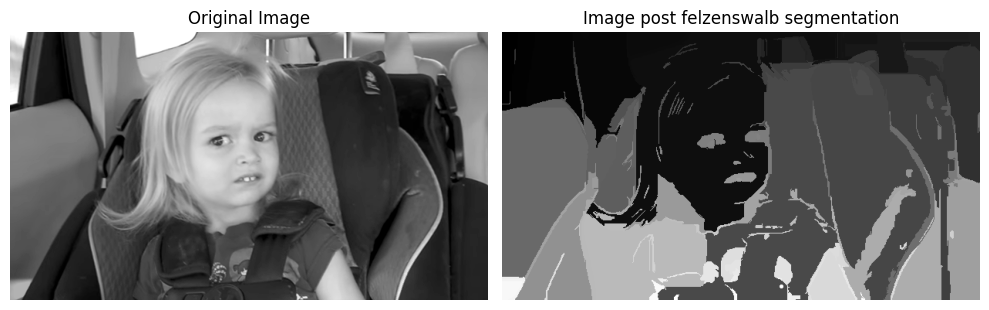

In [5]:
# Plot the original image and the image with segmentation
torch_snippets.subplots(
    [img, segments_fz],
    titles = ['Original Image', 'Image post felzenswalb segmentation'],
    sz = 10,
    nc = 2
)

Результат следующий - пиксели, принадлежащие к одной группе, имеют одинаковые значения. Пиксели с одинаковыми значениями образуют region proposals. Это нам поможет в обнаружении объектов, так как мы передаем каждый region proposal в модель и будем просить предсказать является ли region proposal фоном или например объектом. Кроме того, если это объект, то это нам поможет определить смещение для получения более точного (узкого) regional proposal'a, который будет соответствовать объекту, а также нам будет доступен класс, соответствующий содержимому внутри данной границы решения. Теперь осталось реализовать SelectiveSearch для того, чтобы получить region proposal-ы для заданного изображения. 

### [Selective Search](https://www.geeksforgeeks.org/selective-search-for-object-detection-r-cnn/) 

---


In [6]:
# Define the function that takes an image as the input parameter and fetches the region proposals from that image
def extract_candidates(img):
    # fetch the candidate regions within the image using the selective_search method that we've imported above
    img_lbls, regions = selectivesearch.selective_search(img, scale=200, min_size=10)
    # Calculate the image area and initialize a list (candidates) that we will be using to store the candidates that pass a defined threshold
    img_area = np.prod(img.shape[:2])
    # print(img_area.shape)
    candidates = []
    # Fetch only those candidates (regions) that are over 5% of the total image area and less that or equal to 100% of the image area
    for region in regions:
        if region['rect'] in candidates:
            continue
        if region['size'] < (0.05 * img_area):
            continue
        if region['size'] > (1 * img_area):
            continue
        x, y, w, h = region['rect']
        candidates.append(list(region['rect']))
    return candidates

D:\hw\venv\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


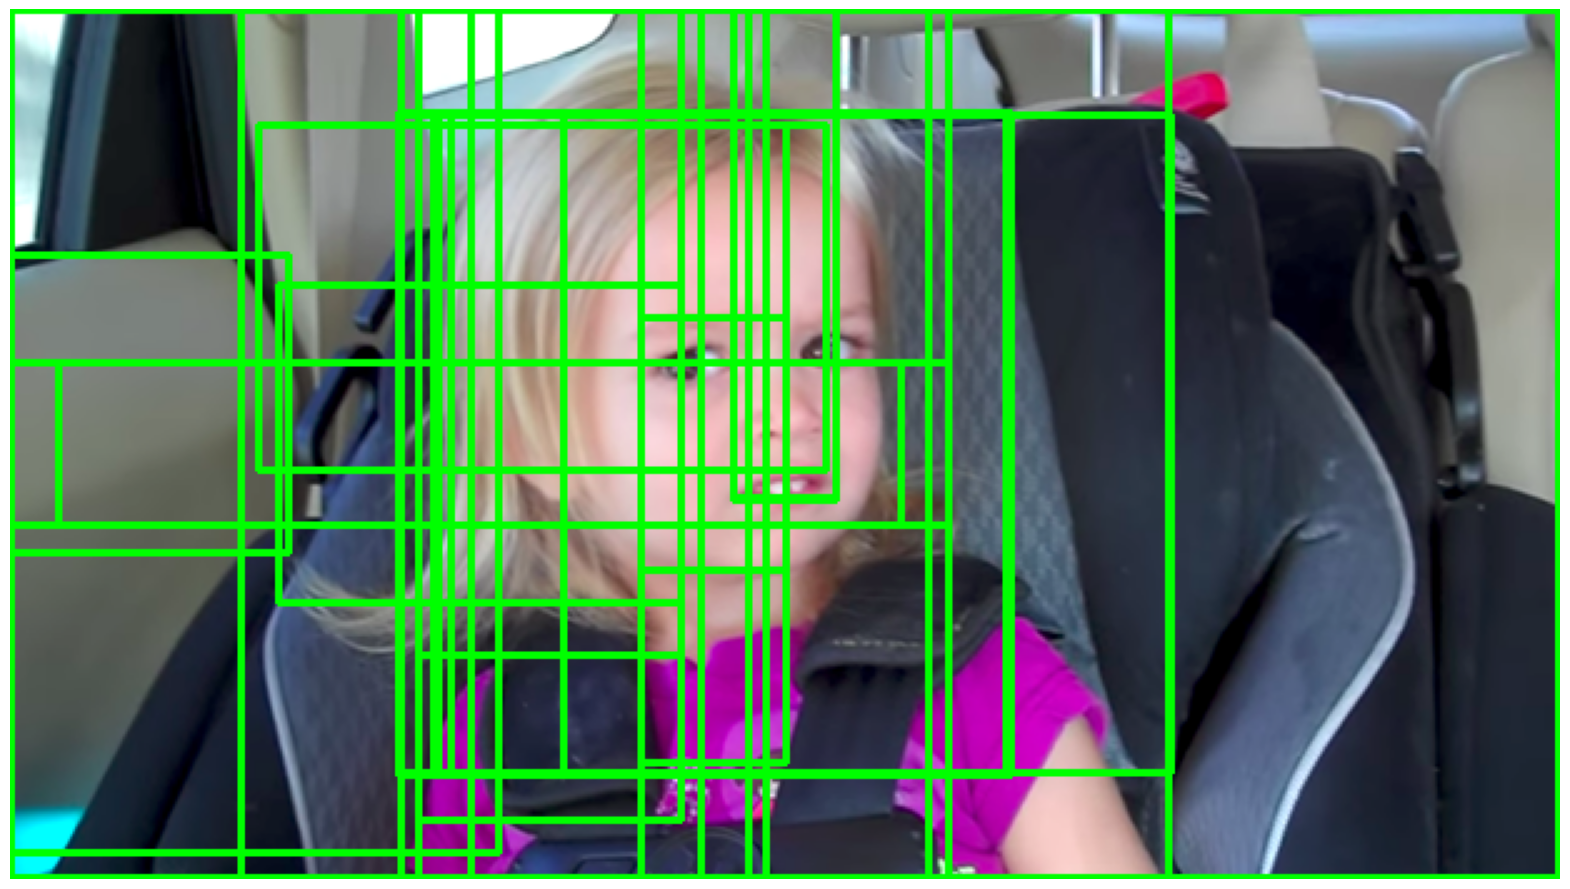

In [7]:
# Find the candidates
img = torch_snippets.read('./../data/penny.png', 1)
candidates = extract_candidates(img)
torch_snippets.show(img, bbs = candidates)

Рамки на картинке представляют с собой те самые region proposals, которые были полученны в результате работы алгоритма selective search. 

Окей, теперь у насть есть region proposals, но как мы их можем теперь использовать для того, чтобы решить задачу обнаружения объекта и локализации объекта?


Один простой подход: Region Proposal, который имеет самый высокий уровень пересечения с ground truth объектом на изображении, будет помечаться как содержащий объект, а с низким наоборот - фон объекта. Но так как мы работаем с цифрами, нам необходимо как-то эмпирически доказать что в нашей предполагаемой области все таки есть объект (сколько данного объекта, как точно мы захватили объект и так далее).


Как мы можем эту идею сформировать?

### Intersection over Union (IoU)

----

Допустим, мы придумали как предсказывать regional proposal и bounding box'ы. Что теперь? Как измерить качество и точность нашего предсказания? 

Все довольно просто - на помощь нам всегда может придти такая концепция метрики как **Intersection over Union (IoU)**

В чем логический смысл и концепция данной метрики:
**Intersection ("перекрытие", "пересечение")** - измеряет степень покрытия предсказанных и реальных рамок (bounding box'ов)
**Union (объединение)** - измеряет общее пространство, возможное для перекрытия между двумя рамками к суммарной области обеих рамок.

Визуально это можно интерпретировать следующим образом:

![](./../src/imgs/iou_metric.png)



И пример работы метрики:

![](./../src/imgs/iou_metric_scores.png)

In [8]:
# Function that takes 2 bounding boxes as input and return IoU as the output
def get_iou(boxA, boxB, epsilon=1e-5):
    # epsilon parameter is for the scenario when the union between 2 boxes is 0 (division by zero error). 
    # Each of the bounding boxes has 4 values corresponding to the 4 corners of the bounding box
    
    # calculate the coordinaties of the intersection box
    x1 = max(boxA[0], boxB[0]) # x1 is storing the max value of the left-most x-value between 2 bounding boxes
    x2 = min(boxA[2], boxB[2])
    y1 = max(boxA[1], boxB[1]) # y1 is storing the topmost y-value and x2 and y2 the right-most x-value bottom most y-value respectively
    y2 = min(boxA[3], boxB[3]) 
    
    # calculating the width and height corresponding to the intersection area (overlapping region)
    width = (x2 - x1)
    height = (y2 - y1)
    
    # Calculate the overlap area
    if (width < 0 ) or (height < 0):
        return 0.0
    area_overlap = float(width) * float(height)
    
    # Calculate the combined area corresponding to the 2 bounding boxes
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    
    # calculate IoU metric
    iou = area_overlap/(area_combined+epsilon)
    return iou

### Short Max Suppression - выбираем bounding box'ы не перебирая все пространство.

----

Предположим у нас ситуация, когда генерируется огромное количество region proposal'ов, все они значительно в той или иной мере начинают перекрывать друг друга. По сути, получается ситуация, что все предсказанные координаты для bounding box'а значительно перекрывают друг друга, формируя огромное пространство выбора и проверки для таких регионов, что довольно проблематично, так как перебирать такое огромное количество областей не очень то и эффективно и с этим что-то надо делать.

Здесь нам поможет подход который называется **Non-Max Suppression**

В чем идея и подход:

* **Non-Max** под данным термином понимаются границы регионов, не содержащие наибольшей вероятности содержания объекта
* **Suppression** - отбрасывание границ регионов, не содержащих наибольшей вероятности содеражания объекта. 

При инициализации алгоритма мы определяем границу, имеющую наибольшую вероятность, и отбрасываем все остальные границы у которых метрика IoU будет больше определенного порога. В Pytorch данный метод реализован через функцию `nms` из `torchvision.ops`. Функция принимает координаты баундинг бокса, вероятность нахождения объекта в ней и пороговое значение IoU для всех баундинг боксов, чтобы определить баундинг боксы, которые будут сохранены. 


---

### Mean Average Precision


При помощи данной метрики мы оцениваем точность предсказания нашей модели. 

Как мы помним Precision:

#### $Precision = \frac{True Positives}{(True Posisitives + False Negatives)}$


* True Positive относится к банудинг боксам, которые предсказали правильный класс объектов и у которых IoU больше чем заданное ограничение
* False Positive относится к баундинг боксам, которые предсказали неправильный класс или пересекаются с объектем меньше чем заданное ограничение
* Average Precision - % точности, значения которого рассчитываются при разных метриках IoU при заданных ограничениях
* mAP: средняя точность расчитанная при помощи различных ограничений IoU по всем классам внтури датасета


### R-CNN для кастомных объектов для задачи Object Detection:

---

R-CNN - **Region-Based Convolutional Neural Network**. Region-based - часть отвечающая за формирование region proposals. Они здесь используются для идентификации объектов на изображении. R-CNN помогает идентифицировать как объекты, которые присутствуют на изображении, так и их точное расположение (координаты) на изображении. 

![](./../src/imgs/rcnn_architecture.png)


#### Шаги:
1. Сформировать region proposal'ы для картинки. Необходимо убедиться, что **мы извлекаем большое количество таких регионов** чтобы не пропустить ни одного потенциального объекта на изображении.
2. Изменить размер (warp step) для всех выделенных областей (регионов), чтобы получить изображения одинакового размера, которые пойдут дальше в сверточную нейронную сеть.
3. Необходимо передать полученные данные из шага 2 дальше в нейронную сеть (сверточную). Обычно используется предварительно обученная архитектура VGG16 или ResNet50. После того как передали данные - необходимо извлечь сформированные признаки в полносвязном слое (FCNN).
4. Создаем данные для обучения модели, где входные данные - это признаки изображения, извлеченные путем извлечения регионов через предварительно обученую модель, а выходными - класс соответствующий каждому регион пропоузалу и плюс смещение его относительно истинного значения.
5. Соединяем 2-а выхода из нейронной сети (один отвечающий за лейбл, другой за формирование баундинг бокса).
6. Считаем ошибку и минимизируем ее тренирую алгоритм.

Посмотрим как это происходит на практике:

### Загрузка датасета:

---

Все будем тестировать на следующем датасете, который вы можете скачать по [ссылке](https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv) и [link](https://www.kaggle.com/datasets/sizhky/openimagesbustrucks)

In [9]:
from torch_snippets import * 
import selectivesearch
from torchvision import transforms, models, datasets
from torchvision.ops import nms # Intersection over union 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

У нас есть датасет, но это только начало, прежде чем его использовать, его необходимо подготовить:

1. Необходимо получить каждое изображение и соответствующий класс для него + баундинг бокс 
2. Необходимо получить regional proposal для каждого изображения, соответствующую метрику IoU для каждого изображения для того чтобы скорректировать region proposal по отношению к истинному объекту
3. Необходимо присвоить числовые метки (лейблы) для каждого класса (также тем дополнительным классам которые присутствуют на изображении) у которых IoU ниже порогового значения
4. Необходимо изменить размер для каждого region proposal'a до размера соответствующего входу сети.

In [5]:
IMAGE_ROOT = "./data/open-images-bus-trucks/images"
DF_RAW = pd.read_csv("./data/open-images-bus-trucks/df.csv")


# XMin, XMax, YMin and YMax correspond to the ground truth of the bounding box of the image
# LabelName provides the class of image
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [6]:
# Define a class that returns the image and its corresponding class (label) and ground truth along with the file path of the image
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    
    def __len__(self):
        return len(self.unique_images)
    
    # define the __getitem__ method where we fetch the image (by imageID) corresponding index (ix), bounding box coords (boxes), classes and return the image, 
    # bounding box, class and the image pass
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        # Convert from BGR to RGB
        image = cv2.imread(image_path, 1)[...,::-1]
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
    
    

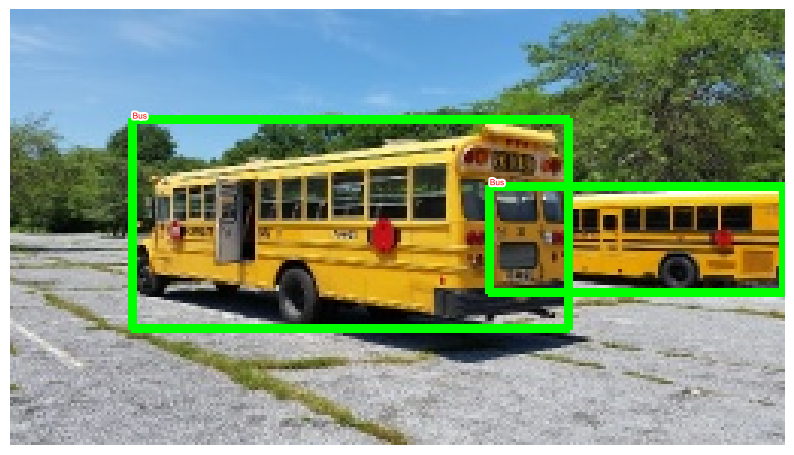

In [10]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[11]
show(im, bbs=bbs, texts=clss, sz=10)

In [12]:
# Define the extract candidates and extract iou
def extract_candidates(img):
    img_lbl,regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates


def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [13]:
# Fetching region proposals and the ground truth of offset or creating input-output values for the model

# The input: candidates that are extracted using the selectivesearch method 
# The output: the class corresponding to candidates and the offset of the candidates with respect to the bounding box it overlaps

# Initialize empty lists to store file paths, ground truth bounding boxes, classes, delta offest of a bounding box with region proposals, region proposals locations and the IoU of region proposals with ground truth
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

# Loop through the dataset and populate the lists initialized above
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    
    # Extract candidates from rach image in absolute pixel values using extract_candidates function that we wrote
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    # Extract ious
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    
    # Loop through each candidate and store the XMin(cx), YMin(cy), XMax(cX) and YMax(cY) values of a candidate
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        # Extract the IoU corresponding to the candidate with respect to all the ground truth bounding boxes
        candidate_ious = ious[jx]
        # Find the index of a candidate (best_iou_at) that has the highest IoU and the corresponding ground truth (best_bb)
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # If IoU is greater that a threshold assign the label of class corresponding to the candidate and the background
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        # Fetch the offsets (delta) to transform the current proposal into the candidate taht is the best region proposal 
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    # Append the file paths, IoU, roi, class delta and ground truth bounding boxes
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
    
    
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

D:\hw\venv\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
D:\hw\venv\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
D:\hw\venv\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
D:\hw\venv\Lib\site-packages\skimage\feature\texture.py

In [14]:
# Assign the indices to each class
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

In [15]:
# Create the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [16]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        
    def __len__(self): return len(self.fpaths)
    
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [42]:
# Create training and validation datasets and dataloaders
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

### R-CNN Network. Архитектура

Как поступать:
1. Необходимо определить фундамент архитектуры VGG (либо иной CNN которую вы будете использовать)
2. Получите признаки после прохождения ваших данных через аугментацию и через дотренированную модель
3. К VGG необходимо присвоить новый линейный слов с сигмоидальной функцией активации для предсказания класса для соответствующего сформированного региона
4. Также необходимо присвоить новый линейный слов для прогнозирования 4-х координат для баундинг бокса
5. Задайте функцию потерь для каждой из задач (3 и 4).
6. Обучите модель предсказывать класс и 4 координаты для объекта



In [43]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()

for param in vgg_backbone.parameters():
    param.requires_grad = False
    
    
vgg_backbone.eval().to(device)

D:\hw\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\hw\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        # The loss functions corresponding to class prediction (cel) and bounding box offset (sl1)
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss() # MAE
    
    # Forward method where we pass the image through a VGG backbone (feature extractor) to fetch features which are further passed through the methods 
    # corresponding to classification and bounding box regression to fetch the probabilities across classes (cls_score) and the bounding box offsets (bbox)
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [18]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [19]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [47]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5

log = Report(n_epochs)
     

C:\Users\murmo\AppData\Local\Temp\ipykernel_34884\4275183504.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.702  val_loc_loss: 0.471  val_regr_loss: 0.123  val_acc: 0.870  (875.03s - 0.00s remaining)))))

100%|██████████| 106/106 [00:00<00:00, 3785.92it/s]


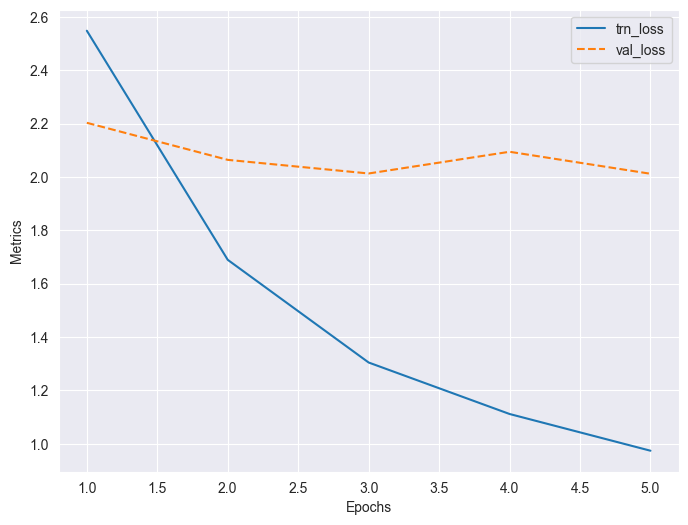

In [48]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [20]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

D:\hw\venv\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


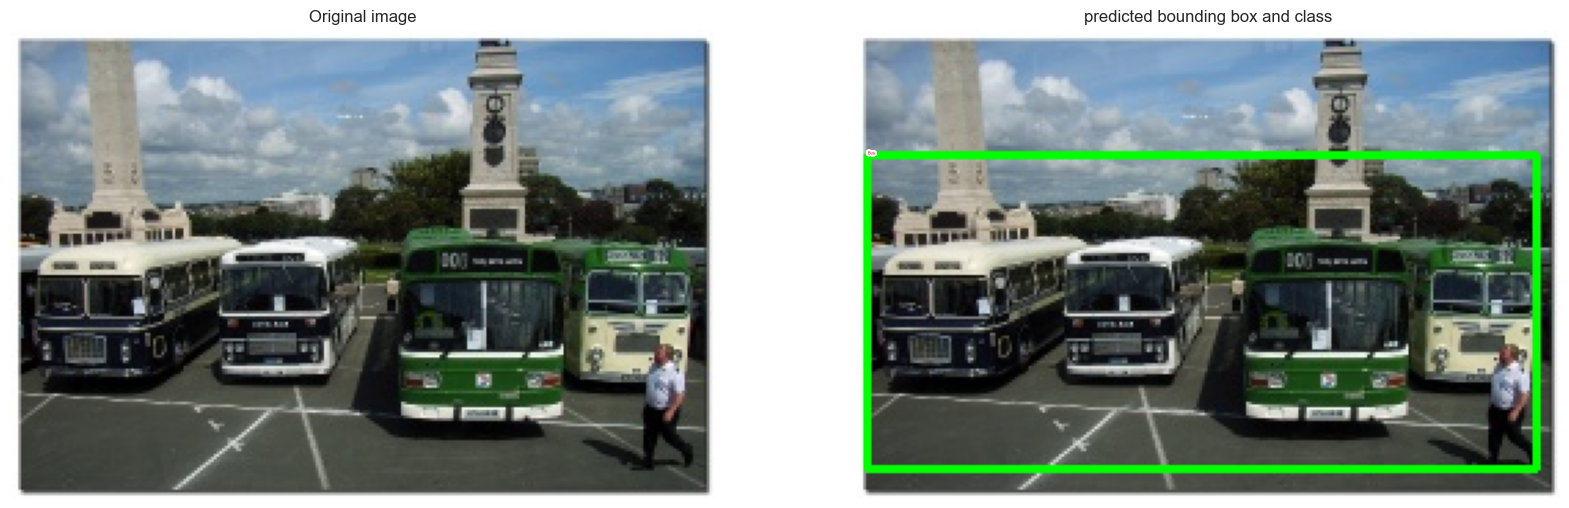

((4, 45, 247, 159), 'Bus', 0.77972215)

In [53]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[17]
test_predictions(fpath)

### Fast R-CNN. Custom object detectors.

----

Одним из основных недостатков R-CNN является значительное время, затрачиваемое на генерацию прогнозов, так как узким местом является генерация region proposal'ов для каждого изображения, изменения размеров регионов и извлечение признаков соответствующих каждому отдельному региону.

Fast R-CNN обходит эту проблему, пропуская все изображение через предварительно обученную модель для извлечения признаков, а затем получая область признаков, соответствующую regional proposal'y (которые получены в результате селективного поиска) исходного изображения.

Пример работы архитектуры:

![](./../src/imgs/fastrcnn_arch.png)


Краткое описание работы архитектуры:
1. Мы пропускаем изображение через предварительно обученную модель для извлечения признаков перед flattening layer. В результате получаем на выходе активационные карты (карты признаков).
2. Далее извлекаем regional proposals для соответствующего изображения. 
3. Извлекаем карты активаций которые соответствуют нашим region proposals 
4. Пропускаем карты активаций которые соответствуют region proposal'ам через слов ROI (Region of Interest) который по сути представляет из себя пуллинг слой. Это по сути дела замена варпу в классическом подходе R-CNN
5. Далее пропускаем выход из пуллинга ROI через fully connected layer
6. Тренируем модель на 2 задачи: 1) Предсказывать класс и 2) Предсказывать координаты boundin box'a

In [21]:
class FRCNNDataset(Dataset):
    # returns images, labels, ground truths, region proposals and the delta corresponding to each region proposal
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        
    def __len__(self): 
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        # rois matrix holds information regarding which ROI belongs to which image in the batch
        rois = torch.Tensor(rois).float().to(device)
        # rixs is a list of indexes. Each integer in the list associates the corresponding bounding box with the appropriate image
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [22]:
from torch.utils.data import TensorDataset, DataLoader

n_train = 9*len(FPATHS)//10

train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])


train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [23]:
from torchvision.ops import RoIPool


class FRCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Load the VGG16 pretrained model and freeze the parameters
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        
        for param in rawnet.features.parameters():
            param.requires_grad = True
        
        # Extract the features until the last layer
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        
        # RoIPool extracts 7x7 output. Spatial scale if the factor by which proposals need to be shrunk so that every output has the same shape 
        # prior to passing through the flatten layer. Images are 224x224 in size, while the feature map is 14x14 in size
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 512*7*7
        # the output heads -> cls_score and bbox
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
        
    def forward(self, input, rois, ridx):
        res = input
        res = self.seq(res)
        # Create a matrix of rois as input for self.roipool by concatenating ridx as the 1st column and the next four columns being the absolute values of the region proposal bounding boxes
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        return cls_score, bbox
    
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [24]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

D:\hw\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\hw\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\murmo/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:28<00:00, 19.4MB/s] 
C:\Users\murmo\AppData\Local\Temp\ipykernel_38128\1549260036.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.nda

EPOCH: 1.000  trn_loc_loss: 0.858  val_regr_loss: 0.090  val_loc_loss: 0.661  trn_acc: 0.648  trn_regr_loss: 0.110  trn_loss: 1.955  val_loss: 1.563  val_acc: 0.742  (9.99s - 39.97s remaining)
EPOCH: 2.000  trn_loc_loss: 0.631  val_regr_loss: 0.086  val_loc_loss: 0.615  trn_acc: 0.757  trn_regr_loss: 0.082  trn_loss: 1.453  val_loss: 1.472  val_acc: 0.755  (17.27s - 25.91s remaining)
EPOCH: 3.000  trn_loc_loss: 0.517  val_regr_loss: 0.083  val_loc_loss: 0.599  trn_acc: 0.809  trn_regr_loss: 0.063  trn_loss: 1.145  val_loss: 1.425  val_acc: 0.757  (24.57s - 16.38s remaining)
EPOCH: 4.000  trn_loc_loss: 0.433  val_regr_loss: 0.082  val_loc_loss: 0.597  trn_acc: 0.847  trn_regr_loss: 0.055  trn_loss: 0.983  val_loss: 1.418  val_acc: 0.760  (32.02s - 8.01s remaining)
EPOCH: 5.000  trn_loc_loss: 0.367  val_regr_loss: 0.078  val_loc_loss: 0.597  trn_acc: 0.879  trn_regr_loss: 0.049  trn_loss: 0.854  val_loss: 1.374  val_acc: 0.757  (39.46s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 3785.83it/s]


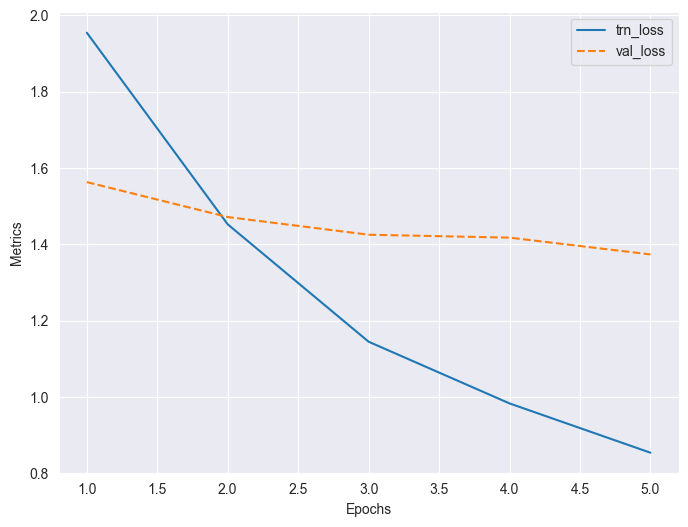

In [25]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

D:\hw\venv\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


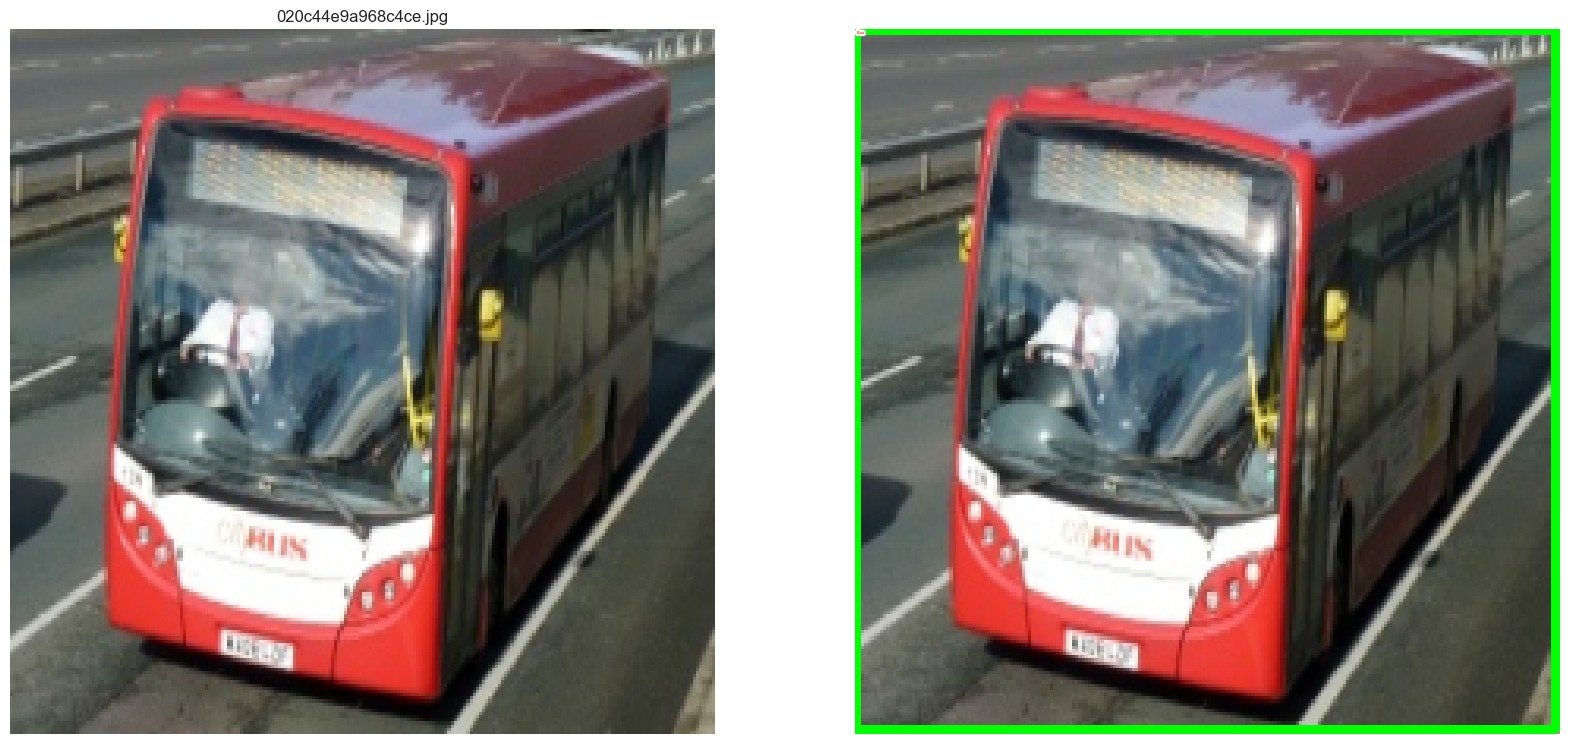

In [30]:
test_predictions(test_ds[15][-1])

Таким образом мы улучшили скорость инференса, но тем не менее, этого все равно недостаточно, чтобы использовать решение в реальном времени (инференс 0.5 сек). Так как мы до сих пор используем подход с разными моделями для генерации region proposals и для предсказания класса и координат для боксов.